In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib

In [6]:
# Load the dataset
df = pd.read_csv('../data/heart.csv')

## Train Test Split

In [7]:
# select columns with object data type
object_col = df.select_dtypes(include='object').columns

# convert the columns to categorical
for col in object_col:
    df[col] = df[col].astype('category')

In [8]:
# locate the drop the only entry with 'RestingBP' = 0
df.drop(df[df['RestingBP'] == 0].index, inplace = True)

In [9]:
# slice df to features and target variable
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

# train test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## Imputation

In [10]:
# compute statistics from training set
chol_median = X_train[X_train['Cholesterol'] != 0].groupby(y_train)
chol_median = chol_median['Cholesterol'].median()

In [11]:
# replace 0 values in training set 'Cholesterol' with median values from training median
for status, median_val in chol_median.items():
    train_mask = (X_train['Cholesterol'] == 0) & (y_train == status)
    X_train.loc[train_mask, 'Cholesterol'] = median_val

In [12]:
# replace 0 values in testing set 'Cholesterol' with median values from training median
for status, median_val in chol_median.items():
    test_mask = (X_test['Cholesterol'] ==0) & (y_test == status)
    X_test.loc[test_mask, 'Cholesterol'] = median_val

In [13]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,184.0,52.467391,9.307675,28.0,46.00,53.0,60.000,75.0
RestingBP,184.0,130.809783,16.564552,80.0,120.00,130.0,140.000,185.0
Cholesterol,184.0,240.385870,50.911238,132.0,208.75,243.5,258.000,518.0
FastingBS,184.0,0.233696,0.424335,0.0,0.00,0.0,0.000,1.0
MaxHR,184.0,137.065217,24.893129,80.0,120.00,138.0,155.000,194.0
Oldpeak,184.0,0.954348,1.054671,-0.1,0.00,0.6,1.725,5.6


In [14]:
# One-hot encode categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align the training and testing dataframes
X_train, X_test = X_train.align(X_test, join = 'Left', axis = 1, fill_value = 0)


In [15]:
X_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
161,49,128,212,0,96,0.0,True,False,False,False,True,False,True,True,False
604,68,134,254,1,151,0.0,True,False,True,False,True,False,True,False,True
659,59,126,218,1,134,2.2,True,False,True,False,True,False,False,True,False
793,67,125,254,1,163,0.2,True,False,False,False,True,False,False,True,False
140,52,160,331,0,94,2.5,True,False,False,False,True,False,True,True,False


In [16]:
X_test.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
645,57,128,229,0,150,0.4,True,False,True,False,False,False,False,True,False
771,55,140,217,0,111,5.6,True,False,False,False,True,False,True,False,False
468,62,152,153,0,97,1.6,True,False,False,False,False,True,True,False,True
736,54,122,286,0,116,3.2,True,False,False,False,False,False,True,True,False
892,39,138,220,0,152,0.0,False,False,True,False,True,False,False,True,False


# Random Forest

## Random Forest

In [17]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    random_state=42,
    class_weight='balanced'
    )

In [18]:
# fit the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=500,
                       random_state=42)

In [19]:
# generate predictions
rf_pred = rf_model.predict(X_test)

In [20]:
# confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_pred))

# print evaluation metrics
print(f'Accuracy : {accuracy_score(y_test, rf_pred):.4f}')
print(f'precision: {precision_score(y_test, rf_pred):.4f}')
print(f'recall: {recall_score(y_test, rf_pred):.4f}')

Confusion Matrix:
[[72 10]
 [ 8 94]]
Accuracy : 0.9022
precision: 0.9038
recall: 0.9216


In [21]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

The performance of the model by training with Random Forest Classifier is 0.9022, without hyperparameter tuning.

Precision: 0.9038, Recall: 0.9216, Accuracy: 0.9022.

The model prediction shows satisfying results even without hyperparameter tuning with grid search.

## Random Forest with stratified CV and Grid search/Bayes search

In [22]:
# parameters for grid search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [23]:
scv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [24]:
rf = RandomForestClassifier( class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = scv,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\TCL0011\AppData\Local\anaconda3\envs\ml1\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=2)

In [25]:
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best traning score: {grid_search.score(X_train, y_train):.4f}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best traning score: 0.9645
Best cross-validation score: 0.8650


The traning score is higher than the cv score by around 10%, it may indicate a bit of overfitting.

We can try to increase the regularization to restrict the model's overfitting probability.

Here, Bayessearch will be used because grid search is computational intensive, and Byessearch provide a quicker training time.

In [26]:
# Further refining the hyperparameters
new_param_grid = {
    'n_estimators': [200, 225, 250, 275],
    'max_depth': [8, 9, 10, 11, 12],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [2, 3, 4],
    'criterion' : ['gini'],
    'max_leaf_nodes' : [None, 10, 20, 30, 40]
}

In [27]:
# use bayessearch for hyperparameter tuning
opt = BayesSearchCV(
    estimator = rf,
    search_spaces = new_param_grid,
    n_iter = 32,
    cv = scv,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 2
)

opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(class_weight='balanced',
                                               random_state=42),
              n_iter=32, n_jobs=-1, scoring='accuracy',
              search_spaces={'criterion': ['gini'],
                             'max_depth': [8, 9, 10, 11, 12],
                             'max_features': ['sqrt', 'log2'],
                             'max_leaf_nodes': [None, 10, 20, 30, 40],
                             'min_samples_leaf': [1, 2, 3],
                             'min_samples_split': [2, 3, 4],
                             'n_estimators': [200, 225, 250, 275]},
              verbose=2)

In [28]:
print(f'Best parameters: {opt.best_params_}')
print(f'Best training score: {opt.score(X_train, y_train):.4f}')
print(f'Best cross-validation score: {opt.best_score_:.4f}')

Best parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 10), ('max_features', 'sqrt'), ('max_leaf_nodes', 40), ('min_samples_leaf', 2), ('min_samples_split', 3), ('n_estimators', 225)])
Best training score: 0.9291
Best cross-validation score: 0.8609


The trianing and CV score is now closer with each other, with less than 10%. 

We accept the hyperparameter found by Bayessearch and apply it to the testing data.

## Final model and prediction

In [29]:
# save best model
best_rf = opt.best_estimator_

# predict testing set
rf_test_pred = best_rf.predict(X_test)

# evaluation metrics
print('confusio matrix:')
print(confusion_matrix(y_test, rf_test_pred))
print(f'Random Forest final model Accuracy : {accuracy_score(y_test, rf_test_pred):.4f}')
print(f'Random Forest final model Precision : {precision_score(y_test, rf_test_pred):.4f}')
print(f'Random Forest final model Recall : {recall_score(y_test, rf_test_pred):.4f}')

# calculate the ROC-AUC score
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC: {auc:.4f}")

confusio matrix:
[[71 11]
 [11 91]]
Random Forest final model Accuracy : 0.8804
Random Forest final model Precision : 0.8922
Random Forest final model Recall : 0.8922
ROC-AUC: 0.9397


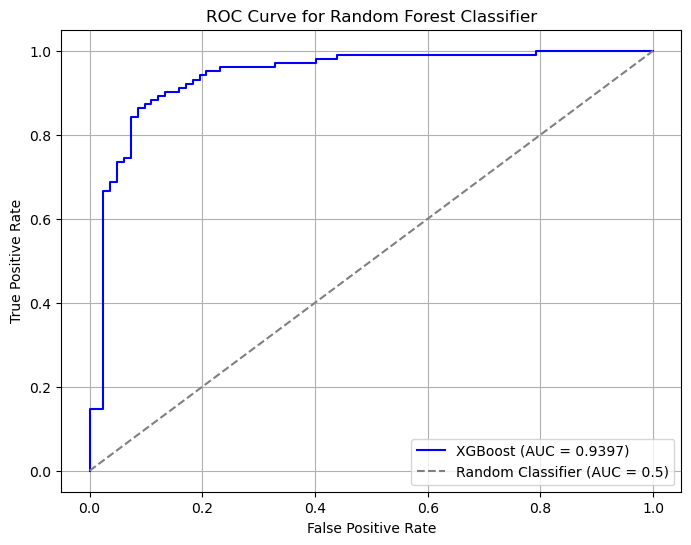

In [30]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [31]:
# save the final xgboost model
joblib.dump(best_rf, '../model/rf_model.joblib')

['../model/rf_model.joblib']

After tuning hyperparameters, the final model acheive Accuracy : 0.8804, Precision : 0.8922, Recall : 0.8922

By the following hyperparameters:

............................................................................................

('criterion', 'gini'),

('max_depth', 10), 

('max_features', 'log2'), 

('max_leaf_nodes', 40), 

('min_samples_leaf', 2), 

('min_samples_split', 2), 

('n_estimators', 225)

............................................................................................

# XGBoost

In [55]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [56]:
xgb_model.fit(X_train, y_train)

c:\Users\TCL0011\AppData\Local\anaconda3\envs\ml1\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:08:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [57]:
xgb_pred = xgb_model.predict(X_test)

In [76]:
# Confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_pred))

# print evaluation metrics
print(f'XGBoost training score: {xgb_model.score(X_train, y_train):.4f}')
print(f'XGBoost Accuracy : {accuracy_score(y_test, xgb_pred):.4f}')
print(f'XGBoost Precision : {precision_score(y_test, xgb_pred):.4f}')
print(f'XGBoost Recall : {recall_score(y_test, xgb_pred):.4f}')

Confusion Matrix:
[[75  7]
 [12 90]]
XGBoost training score: 1.0000
XGBoost Accuracy : 0.8967
XGBoost Precision : 0.9278
XGBoost Recall : 0.8824


Training score from the model is at 1.0, while the testing set accuracy is at 0.8967. indicating a little bit of overfitting, but is generally acceptable since the testing accuracy is near 90%. 

This can also indicates that the model is likely more complex than necessary.

## Hyperparameter tuning

In [ ]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [67]:
# Set up the grid search with cross-validation
grid_search_xgb = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# fit model
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


c:\Users\TCL0011\AppData\Local\anaconda3\envs\ml1\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:44:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=500,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [77]:
# Evaluation matrics
print(f'training accuracy: {grid_search_xgb.score(X_train, y_train):.4f}')
print(f'Best parameters: {grid_search_xgb.best_params_}')
print(f'Best cv score: {grid_search_xgb.best_score_:.4f}')

training accuracy: 0.9823
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Best cv score: 0.8771


With the best hyperparameters, still the model is showing some degree of overfitting

We should experiement with higher regularizations

In [78]:
# new hyperparameter tuning for XGBoost
new_param_grid = {
    'n_estimators': [70, 80, 90, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up the new grid search with cross-validation
new_grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = new_param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

new_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\TCL0011\AppData\Local\anaconda3\envs\ml1\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\TCL0011\AppData\Local\anaconda3\envs\ml1\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:12:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=500,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [70, 80, 90, 100],
                         'subsample': [0.6, 0.8]},
             scoring='accuracy', verbose=2)

In [79]:
# Evaluation metrics
print(f'training accuracy: {new_grid_search.score(X_train, y_train):.4f}')
print(f'Best parameters: {new_grid_search.best_params_}')
print(f'Best cv score: {new_grid_search.best_score_:.4f}')

training accuracy: 0.9359
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
Best cv score: 0.8771


This model demonstrate lowered traiing accuracy, which reduced the chance of overfitting.

the best cv score remains the same at 0.8771, tightening the gap between training accuracy and cv score, indicating a more generalized and robust model.

In [80]:
# further fine tuning
further_param_grid = {
    'n_estimators': [90, 95, 100, 105, 110],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.1, 0.01],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# setup grid search with cross-validation
further_grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = further_param_grid,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

# train the model
further_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


c:\Users\TCL0011\AppData\Local\anaconda3\envs\ml1\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:26:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=500,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.1, 0.01], 'max_depth': [2, 3, 5],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': [90, 95, 100, 105, 110],
                         'subsample': [0.5, 0.6, 0.7]},
             scoring='accuracy', verbose=2)

In [81]:
# Evaluation metrics
print(f'traing accuracy: {further_grid_search.score(X_train, y_train):.4f}')
print(f'Best parameters: {further_grid_search.best_params_}')
print(f'Best cv score: {further_grid_search.best_score_:.4f}')

traing accuracy: 0.9018
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 95, 'subsample': 0.6}
Best cv score: 0.8799


## Final model and prediction

In [92]:
# save the final model
best_xgb_model = further_grid_search.best_estimator_

# predict the test set
y_test_pred = best_xgb_model.predict(X_test)

# evaluation metrics
print('onfusio matrix:')
print(confusion_matrix(y_test, y_test_pred))
print(f'XGBoost final model Accuracy : {accuracy_score(y_test, y_test_pred):.4f}')
print(f'XGBoost final model Precision : {precision_score(y_test, y_test_pred):.4f}')
print(f'XGBoost final model Recall : {recall_score(y_test, y_test_pred):.4f}')

# calculate the ROC-AUC score
y_test_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC: {auc:.4f}")

onfusio matrix:
[[73  9]
 [ 9 93]]
XGBoost final model Accuracy : 0.9022
XGBoost final model Precision : 0.9118
XGBoost final model Recall : 0.9118
ROC-AUC: 0.9534


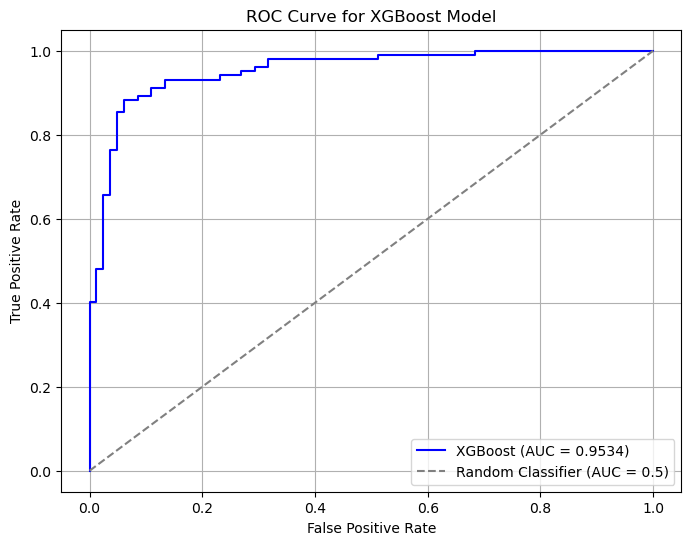

In [93]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The final model acheived accuracy above 90% with satisfying recall and precision. 

The ROC-AUC also shows robust prediction abiliy with ROC value at 0.9534.

In [95]:
# save the final xgboost model
joblib.dump(best_xgb_model, '../model/xgboost_model.joblib')

['../model/xgboost_model.joblib']